# The MLDA sampler

https://docs.pymc.io/en/stable/pymc-examples/examples/samplers/MLDA_simple_linear_regression.html

## Step 1: Generate some data

Here, we generate a vector x of 200 points equally spaced between 0.0 and 1.0. Then we project those onto a straight line with intercept 1.0 and slope 2.0, adding some random noise, resulting in a vector y. The goal is to infer the intercept and slope from x and y, i.e. a very simple linear regression problem.

In [1]:
# Import libraries

import time
import warnings

import arviz             as az
import matplotlib.pyplot as plt
import numpy             as np
import pymc3             as pm

In [28]:
az.style.use('arviz-darkgrid')

warnings.filterwarnings('ignore')

In [29]:
# Generate data

RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

true_intercept = 1
true_slope     = 2
sigma          = 1

size = 200

x = np.linspace(0,1,size)
y = true_intercept + true_slope * x + np.random.normal(0, sigma**2, size)

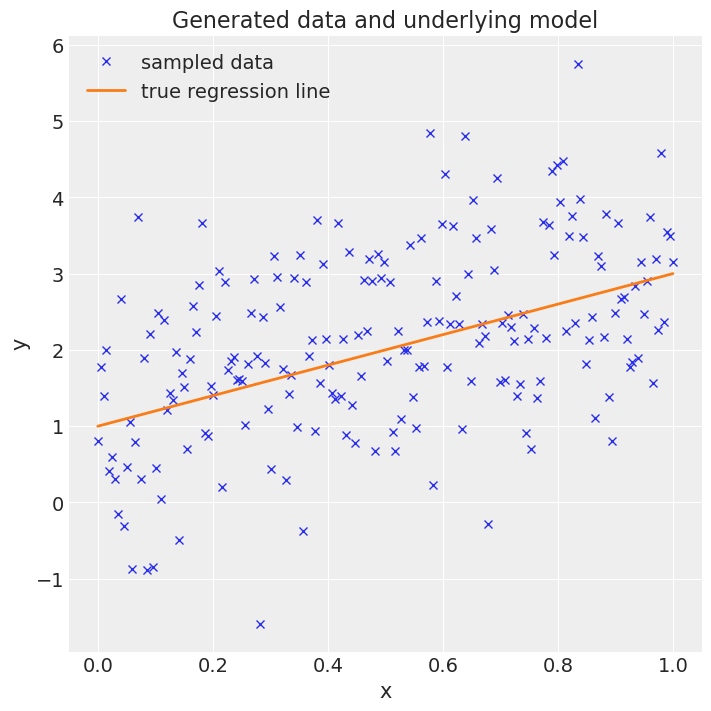

In [30]:
# Plot the data
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_intercept + true_slope * x, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Step 2: Define the fine model

In this step we use the PyMC3 model definition language to define the priors and the likelihood. We choose non-informative Normal priors for both intercept and slope and a Normal likelihood, where we feed in x and y.

In [31]:
# Constructing the fine model

with pm.Model() as fine_model:

    # Define priors

    intercept = pm.Normal('intercept', mu = 0, sigma = 20)
    slope     = pm.Normal('slope',     mu = 0, sigma = 20)

    # Define likelihood

    likelihood = pm.Normal('y', mu = intercept + slope * x, sigma = sigma, observed = y)

## Step 3: Define a coarse model

Here, we define a toy coarse model where coarseness is introduced by using fewer data in the likelihood compared to the fine model, i.e. we only use every 2nd data point from the original data set.

In [32]:
# Thinning the data set

x_coarse = x[::2]
y_coarse = y[::2]

In [33]:
# Constructing the coarse model

with pm.Model() as coarse_model:

    # Define priors

    intercept = pm.Normal('intercept', mu = 0, sigma = 20)
    slope     = pm.Normal('slope',     mu = 0, sigma = 20)

    # Define likelihood

    likelihood = pm.Normal('y', mu = intercept + slope * x_coarse, sigma = sigma, observed = y_coarse)

## Step 4: Draw MCMC samples from the posterior using MLDA

We feed coarse_model to the MLDA instance and we also set subsampling_rate to 10. The subsampling rate is the number of samples drawn in the coarse chain to construct a proposal for the fine chain. In this case, MLDA draws 10 samples in the coarse chain and uses the last one as a proposal for the fine chain. This is accepted or rejected by the fine chain and then control goes back to the coarse chain which generates another 10 samples, etc. Note that pm.MLDA has many other tuning arguments which can be found in the documentation.

Next, we use the universal pm.sample method, passing the MLDA instance to it. This runs MLDA and returns a trace, containing all MCMC samples and various by-products. Here, we also run standard Metropolis and DEMetropolisZ samplers for comparison, which return separate traces. We time the runs to compare later.

Finally, PyMC3 provides various functions to visualise the trace and print summary statistics (two of them are shown below).

In [34]:
with fine_model:

    # Initialize step methods

    step   = pm.MLDA(coarse_models = [coarse_model], subsampling_rates = [10])
    step_2 = pm.Metropolis()
    step_3 = pm.DEMetropolisZ()

    # Sample using MLDA

    t_start   = time.time()
    trace     = pm.sample(draws=6000, chains=4, tune=2000, step=step,   random_seed=RANDOM_SEED)
    runtime   = time.time() - t_start

    # Sample using Metropolis

    t_start   = time.time()
    trace_2   = pm.sample(draws=6000, chains=4, tune=2000, step=step_2, random_seed=RANDOM_SEED)
    runtime_2 = time.time() - t_start

    # Sample using DEMetropolisZ

    t_start   = time.time()
    trace_3   = pm.sample(draws=6000, chains=4, tune=2000, step=step_3, random_seed=RANDOM_SEED)
    runtime_3 = time.time() - t_start

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/step_methods/mlda.py:386: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
/var/folders/zh/jv1b2t351dx2rqz29grjnb_r0000gn/T/ipykernel_31787/3204486182.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace     = pm.sample(draws=6000, chains=4, tune=2000, step=step,   random_seed=RANDOM_SEED)
Multiprocess sampling (4 chains in 4 jobs)
MLDA: [slope, intercept]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 46 seconds.
/var/folders/zh/jv1b2t351dx2rqz29grjnb_r0000gn/T/ipykernel_31787/3204486182.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2   = pm.sample(draws=6000, chains=4, tune=2000, step=step_2, random_seed=RANDOM_SEED)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [slope]
>Metropolis: [intercept]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 12 seconds.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/zh/jv1b2t351dx2rqz29grjnb_r0000gn/T/ipykernel_31787/3204486182.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_3   = pm.sample(draws=6000, chains=4, tune=2000, step=step_3, random_seed=RANDOM_SEED)
Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [slope, intercept]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log

array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>]], dtype=object)

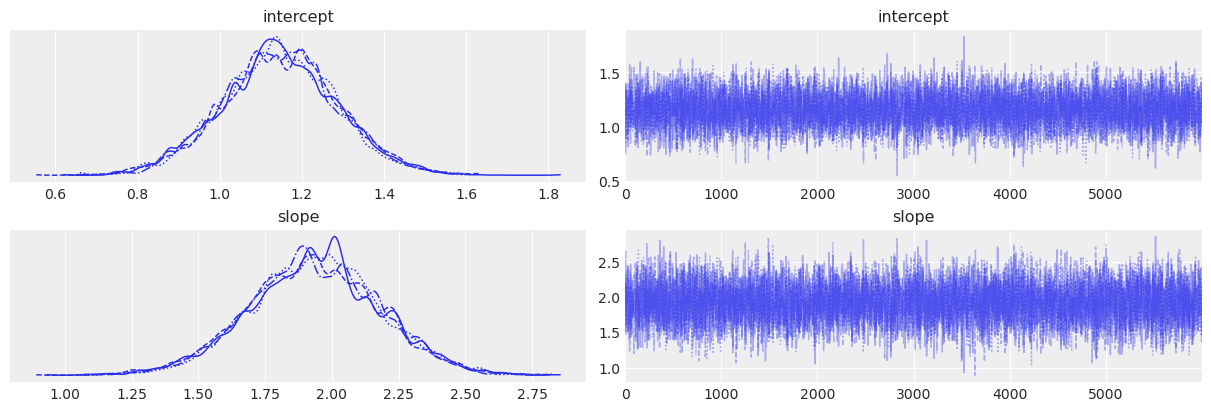

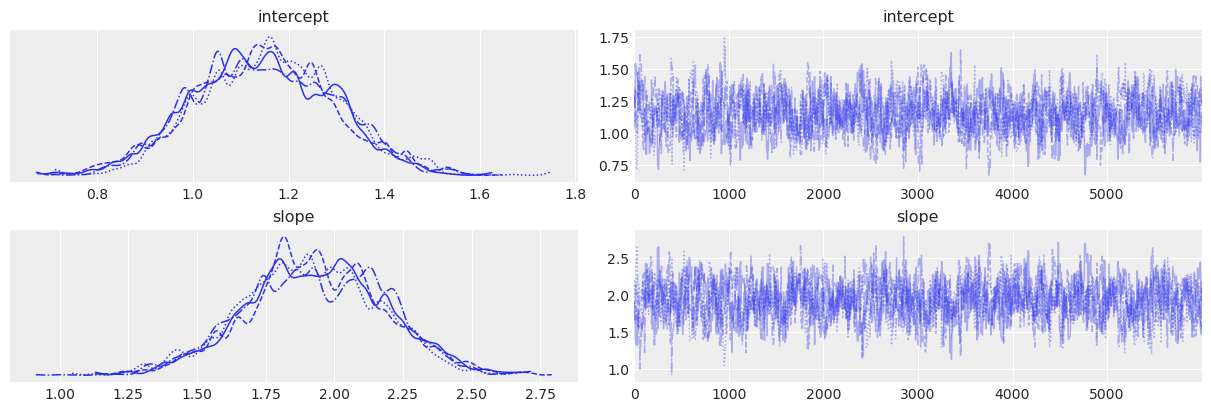

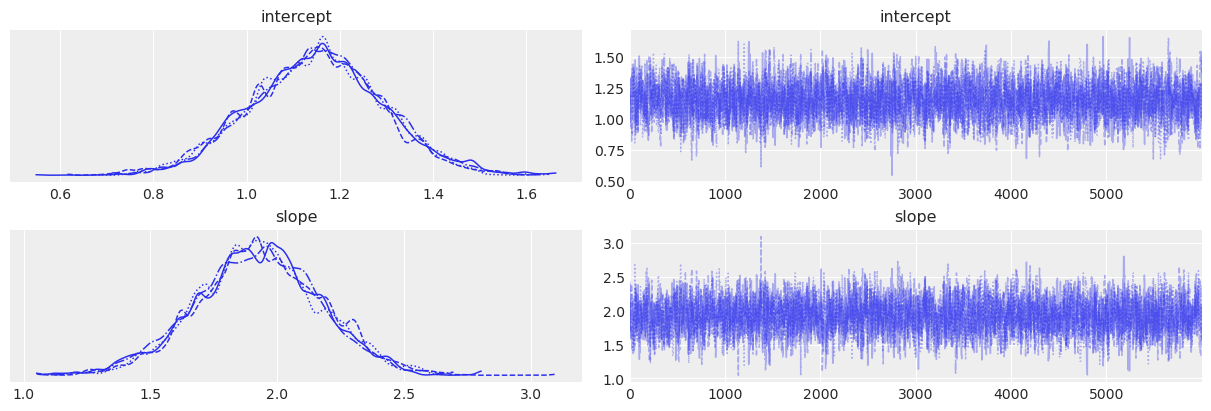

In [35]:
az.plot_trace(trace)
az.plot_trace(trace_2)
az.plot_trace(trace_3)

In [36]:
# Summary statistics for MLDA

az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.146,0.140,0.876,1.406,0.002,0.001,7673.0,7048.0,1.0
slope,1.934,0.244,1.477,2.397,0.003,0.002,7733.0,7577.0,1.0


In [37]:
# Summary statistics for Metropolis

az.summary(trace_2)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.150,0.145,0.875,1.410,0.006,0.004,587.0,1143.0,1.0
slope,1.928,0.251,1.445,2.384,0.010,0.007,596.0,1237.0,1.0


In [38]:
# Summary statistics fro DEMetropolisZ

az.summary(trace_3)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.150,0.141,0.886,1.415,0.003,0.002,3007.0,4414.0,1.0
slope,1.926,0.244,1.457,2.381,0.004,0.003,2956.0,4319.0,1.0


In [39]:
assert all(az.rhat(trace)   < 1.03)
assert all(az.rhat(trace_2) < 1.03)
assert all(az.rhat(trace_3) < 1.03)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


In [40]:
# Display runtimes
print(f"Runtimes: MLDA: {runtime}, Metropolis: {runtime_2}, DEMetropolisZ: {runtime_3}")

Runtimes: MLDA: 46.89739918708801, Metropolis: 13.080968856811523, DEMetropolisZ: 13.816214799880981


## Comments

### Performance:

You can see from the summary statistics above that MLDA’s ESS is ~13x higher than Metropolis and ~2.5x higher than DEMetropolisZ. The runtime of MLDA is ~3.5x larger than either Metropolis or DEMetropolisZ. Therefore in this toy example MLDA is almost an overkill (especially compared to DEMetropolisZ). For more complex problems, where the difference in computational cost between the coarse and fine models/likelihoods is orders of magnitude, MLDA is expected to outperform the other two samplers, as long as the coarse model is reasonably close to the fine one. This case is often enountered in inverse problems in engineering, ecology, imaging, etc where a forward model can be defined with varying coarseness in space and/or time (e.g. subsurface water flow, predator prey models, etc). For an example of this, please see the MLDA_gravity_surveying.ipynb notebook in the same folder.

### Subsampling rate:

The MLDA sampler is based on the assumption that the coarse proposal samples (i.e. the samples proposed from the coarse chain to the fine one) are independent (or almost independent) from each other. In order to generate independent samples, it is necessary to run the coarse chain for an adequate number of iterations to get rid of autocorrelation. Therefore, the higher the autocorrelation in the coarse chain, the more iterations are needed and the larger the subsampling rate should be.

Values larger than the minimum for beating autocorreletion can further improve the proposal (as the distribution is explored better and the proposal are imptoved), and thus ESS. But at the same time more steps cost more computationally. Users are encouraged to do test runs with different subsampling rates to understand which gives the best ESS/sec.

Note that in cases where you have more than one coarse model/level, MLDA allows you to choose a different subsampling rate for each coarse level (as a list of integers when you instantiate the stepper).